Here, I test whether my LSTM net works or not to estimate SGM parameters 

Now I run the real data with eye-close-open data

Convert to dB Scale

The data is too stationery to be used (on Jun 8, 2023)(on Jun 8, 2023)

In [1]:
RUN_PYTHON_SCRIPT = False

False

In [2]:
import sys
sys.path.append("../mypkg")
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT

In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from easydict import EasyDict as edict
from tqdm import trange, tqdm
import time

plt.style.use(FIG_ROOT/"base.mplstyle")

In [4]:
import importlib
import models.lstm
importlib.reload(models.lstm)

<module 'models.lstm' from '/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/models/lstm.py'>

In [5]:
from utils.reparam import theta2raw_torch, raw2theta_torch, raw2theta_np
from spectrome import Brain
from sgm.sgm import SGM
from utils.stable import paras_stable_check
from utils.misc import save_pkl, save_pkl_dict2folder, load_pkl, load_pkl_folder2dict, delta_time
from models.lstm import LSTM_SGM
from models.loss import  weighted_mse_loss, reg_R_loss, lin_R_loss, lin_R_fn, reg_R_fn
from utils.standardize import std_mat, std_vec

In [6]:
# pkgs for pytorch ( Mar 27, 2023) 
import torch
import torch.nn as nn
from torch.functional import F
from torch.optim.lr_scheduler import ExponentialLR

torch.set_default_dtype(torch.float64)
if torch.cuda.is_available():
    torch.cuda.set_device(2)
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)
    torch.backends.cudnn.benchmark = True
else:
    torch.set_default_tensor_type(torch.DoubleTensor)

# Data, fn and paras

In [44]:
meg_root = DATA_ROOT/"MEG-eye-multiFreqs"
fil_paths = list(meg_root.glob("*alpha*wavelet*.pkl"))

psd_all = []
for fil_path in fil_paths:
    data = load_pkl(fil_path);
    psd_all.append(data.spectrogram)
    
psd_all = np.array(psd_all)
# to dB
psd_all = 10 * np.log10(psd_all);
# first several time pts are probmatic
psd_all = psd_all[:, :, :, 20:-20];

freqs = data.freqs
time_pionts = data.times[20:-20];

Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/MEG-eye-multiFreqs/lcmv_DKregion_R2868E_02-st_alpha_20_wavelet_spectrogram.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/MEG-eye-multiFreqs/lcmv_DKregion_R2868E_02-st_alpha_10_wavelet_spectrogram.pkl


In [45]:
# order the new data to make it compatible with the SC and distmat
import pandas as pd
df = pd.read_excel(meg_root/"DK_labs_list.xlsx")
data_roi_order = np.array(df.iloc[:, 0]);

with open(meg_root/"../DK_atlas_36MEG.txt", "r") as f:
    target_roi_order = f.readlines()
target_roi_order = [ix.strip() for ix in target_roi_order][:68]

# the target and data have the same format
_trans_name = lambda input: input.split("_")[1].lower() + "h." + input.split("_")[0].lower()
target_roi_order = [_trans_name(ix) for ix in target_roi_order]

dic = {key:v for key, v in zip(data_roi_order, range(68))};
new_ord = np.array([dic[key] for key in target_roi_order])
psd_all = psd_all[:, new_ord];
psd_all.shape

(2, 68, 39, 320)

In [46]:
# Load the Connectome
brain = Brain.Brain()
brain.add_connectome(DATA_ROOT)
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

In [47]:
# some constant parameters for this file
paras = edict()

## I reorder them in an alphabetical order and I change tauC to tauG (Mar 27, 2023)
## the orginal order is taue, taui, tauC, speed, alpha, gii, gei
## paras.par_low = np.asarray([0.005,0.005,0.005,5, 0.1,0.001,0.001])
## paras.par_high = np.asarray([0.03, 0.20, 0.03,20,  1,    2,  0.7])
##

# alpha, gei, gii, taue, tauG, taui, speed 
paras.par_low = np.array([0.1, 0.001,0.001, 0.005, 0.005, 0.005, 5])
paras.par_high = np.asarray([1, 0.7, 2, 0.03, 0.03, 0.20, 20])
paras.prior_bds = np.array([paras.par_low, paras.par_high]).T
paras.names = ["alpha", "gei", "gii", "Taue", "TauG", "Taui", "Speed"]

paras.C = brain.reducedConnectome
paras.D = brain.distance_matrix
paras.freqs = freqs

# Train the model

In [48]:
trained_model = load_pkl_folder2dict(RES_ROOT/"SGM_net_large", excluding=['opt*'])
sgm_net = trained_model.model;
sgm_net.eval();

Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net_large/freqs.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net_large/loss.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net_large/loss_test.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net_large/model.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net_large/paras.pkl


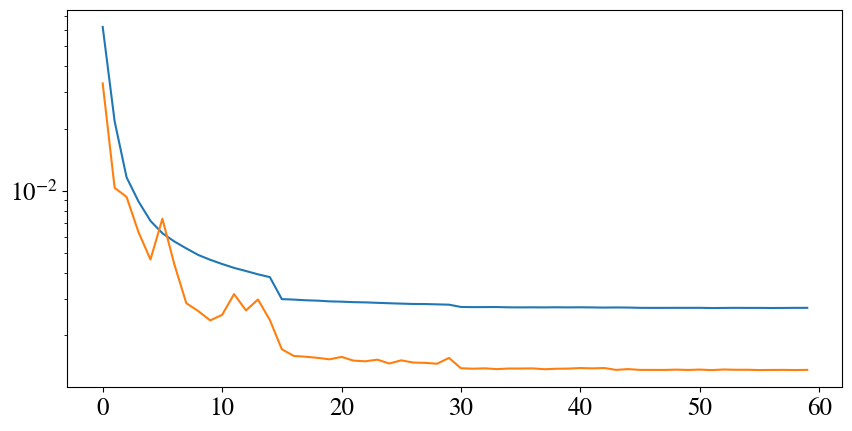

In [49]:
if not RUN_PYTHON_SCRIPT:
    plt.plot(np.array(trained_model.loss)/10)
    plt.plot(trained_model.loss_test)
    #plt.xticks(np.arange(0, 120, 14));
    plt.yscale("log")

In [50]:
def evaluate(all_data):
    num_sub, len_seq, _, _ = all_data.shape
    all_data_raw = torch.tensor(all_data).transpose(1, 0).to(torch.get_default_dtype());
    all_data_input = (all_data_raw - all_data_raw.mean(axis=-1, keepdims=True))/all_data_raw.std(axis=-1, keepdims=True);
    all_data_input = all_data_input.flatten(2);
    
    Y_pred = rnn(all_data_input);
    X_pred = sgm_net(Y_pred.flatten(0, 1));
    corrs = reg_R_fn(all_data_raw.flatten(0, 1), X_pred);
    corrs = corrs.reshape(len_seq, num_sub, -1).transpose(1, 0)
    return corrs.detach().numpy()

In [51]:
paras_rnn = edict()
paras_rnn.batchsize = 128 # no use
paras_rnn.niter = 100
paras_rnn.loss_out = 5
paras_rnn.eval_out = 20
paras_rnn.clip = 10 # from 
paras_rnn.lr_step = 10

paras_rnn.k = 1
paras_rnn.hidden_dim = int(1024*1)
paras_rnn.output_dim = 7
paras_rnn.input_dim = 68*len(paras.freqs)
paras_rnn.is_bidirectional = False
paras_rnn.unstable_pen = 10000 # Whether to filter out the unstable sps or not, if 0 not, if large number, yes
paras_rnn.loss_name = "wmse" # linR, corr, wmse or mse
#paras.names = ["alpha", "gei", "gii", "Taue", "TauG", "Taui", "Speed"]
# 1 dynamic, 0 static
paras_rnn.dy_mask = [1, 1, 1, 1, 1, 1, 0] 
paras_rnn.dy_mask = [0 , 0, 0, 0, 0, 0, 0] 

#  real data, should be num_sub x len_seq x nrois x nfreqs
all_data = psd_all.transpose(0, 3, 1, 2)
all_data_raw = torch.tensor(all_data).transpose(1, 0)
all_data_input = (all_data_raw - all_data_raw.mean(axis=-1, keepdims=True))/all_data_raw.std(axis=-1, keepdims=True);
all_data_input = all_data_input.flatten(2).to(torch.get_default_dtype());

In [52]:
rnn = LSTM_SGM(input_dim=paras_rnn.input_dim, 
               hidden_dim=paras_rnn.hidden_dim, 
               output_dim=paras_rnn.output_dim, 
               is_bidirectional=paras_rnn.is_bidirectional, 
               prior_bds=torch.tensor(paras.prior_bds), 
               k = paras_rnn.k, 
               dy_mask = paras_rnn.dy_mask
)
if paras_rnn.loss_name.startswith("corr"):
    loss_fn = reg_R_loss
elif paras_rnn.loss_name.startswith("linR"):
    loss_fn = lin_R_loss
elif paras_rnn.loss_name.startswith("wmse"):
    loss_fn = weighted_mse_loss
elif paras_rnn.loss_name.startswith("mse"):
    loss_fn = nn.MSELoss()
else:
    raise KeyError("No such loss")

optimizer = torch.optim.AdamW(rnn.parameters(), lr=2e-4, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=0.9, verbose=True)

Adjusting learning rate of group 0 to 2.0000e-04.


In [53]:
# training
loss_cur = 0
losses = []
losses_test = []

t0 = time.time()
sgm_net.eval()
loss_add = 0
for ix in range(paras_rnn.niter):
    rnn.train()
    X_seq = all_data_input
    # Zero the gradients
    optimizer.zero_grad()
    
    theta_pred = rnn(X_seq)
    X_pred = sgm_net(theta_pred.flatten(0, 1))
    loss_main = loss_fn(X_seq.flatten(0, 1).reshape(-1, 68, len(paras.freqs)),
                   X_pred)
    if paras_rnn.unstable_pen > 0:
        unstable_inds = paras_stable_check(theta_pred.flatten(0, 1).detach().numpy());
        unstable_inds = torch.tensor(unstable_inds).reshape(*theta_pred.shape[:2])
        loss_add = (paras_rnn.unstable_pen * unstable_inds.unsqueeze(-1) * theta_pred).mean();
    loss = loss_main + loss_add
    
    # Perform backward pass
    loss.backward()
    
    torch.nn.utils.clip_grad_norm_(rnn.parameters(), paras_rnn.clip)
    # Perform optimization
    optimizer.step()
    
    if ix % paras_rnn.lr_step == (paras_rnn.lr_step-1):
        scheduler.step()
    
    loss_cur = loss_cur + loss_main.item()
    if ix % paras_rnn.loss_out == (paras_rnn.loss_out-1):
        losses.append(loss_cur/paras_rnn.loss_out)
        print(f"At iter {ix+1}/{paras_rnn.niter}, "
              f"the losses are {loss_cur/paras_rnn.loss_out:.5f} (train). "
              f"The time used is {delta_time(t0):.3f}s. "
             )
        loss_cur = 0
        t0 = time.time()
        
    if ix % paras_rnn.eval_out == (paras_rnn.eval_out-1):
        rnn.eval()
        loss_test = evaluate(all_data).mean()
        losses_test.append(loss_test)
        print(f"="*100)
        print(f"At iter {ix+1}/{paras_rnn.niter}, "
              f"the losses on all data are {loss_test:.5f}. "
              f"The time used is {delta_time(t0):.3f}s. "
             )
        print(f"="*100)
        t0 = time.time()
    


At iter 5/100, the losses are 0.21002 (train). The time used is 13.318s. 
Adjusting learning rate of group 0 to 1.8000e-04.
At iter 10/100, the losses are 0.10108 (train). The time used is 10.346s. 
At iter 15/100, the losses are 0.09942 (train). The time used is 10.795s. 
Adjusting learning rate of group 0 to 1.6200e-04.
At iter 20/100, the losses are 0.09750 (train). The time used is 13.407s. 
At iter 20/100, the losses on all data are 0.99208. The time used is 0.273s. 


KeyboardInterrupt: 

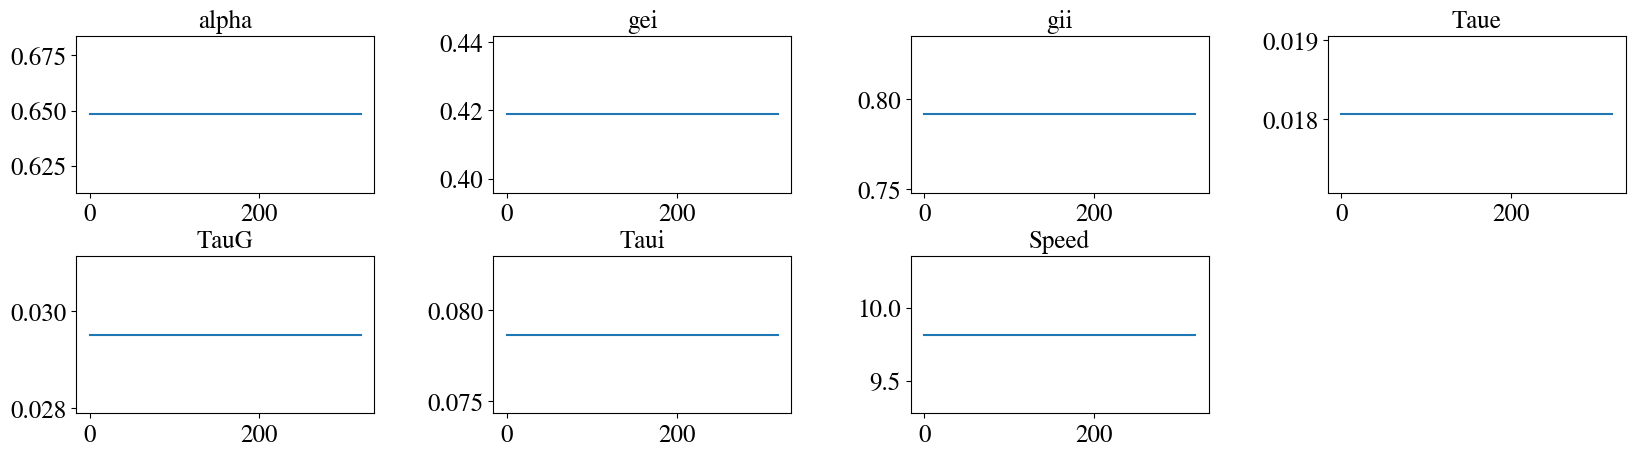

In [54]:
est_sgm_paras = theta_pred.detach().numpy()[:, 0, :];
plt.figure(figsize=[20, 5])
for p_ix in range(7):
    plt.subplot(2, 4, p_ix+1)
    plt.title(paras.names[p_ix])
    plt.plot(est_sgm_paras[:, p_ix])
    

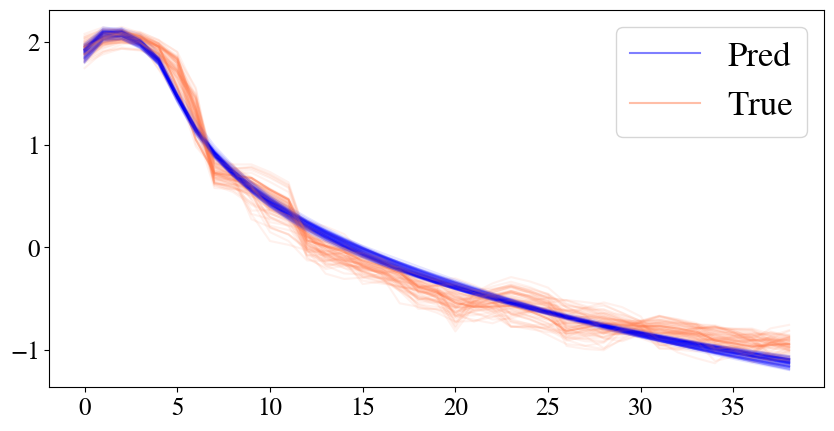

In [56]:
psd_pred = X_pred.detach().numpy()
psd_true = X_seq.flatten(0, 1).reshape(-1, 68, len(paras.freqs)).numpy();
psd_ix = 1
for roi_ix in range(68):
    if roi_ix == 0:
        plt.plot(psd_pred[psd_ix, roi_ix], label="Pred", color="blue", alpha=0.5)
        plt.plot(psd_true[psd_ix, roi_ix], label="True", color="coral", alpha=0.5)
    else:
        plt.plot(psd_pred[psd_ix, roi_ix], color="blue", alpha=0.1)
        plt.plot(psd_true[psd_ix, roi_ix], color="coral", alpha=0.1)
plt.legend()

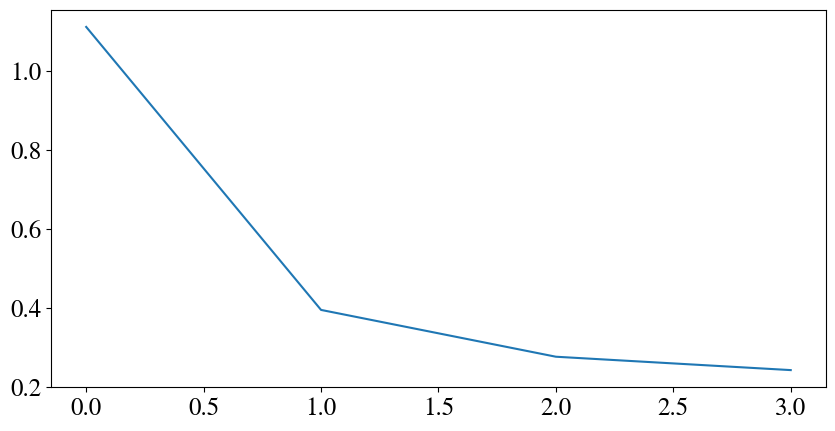

In [43]:
if not RUN_PYTHON_SCRIPT:
    plt.plot(losses[:])
    #plt.yscale("log")

# Save

In [50]:
dy_part = "_".join(np.array(paras.names)[np.array(paras_rnn.dy_mask)==0][:-1])
folder_name = f"LSTM_simu_net_eye_close_{paras_rnn.loss_name}_{dy_part}";
folder_name

'LSTM_simu_net_eye_close_wmse_alpha_gei_gii_Taue_TauG_Taui'

In [51]:
if (RES_ROOT/folder_name).exists():
    trained_model = load_pkl_folder2dict(RES_ROOT/folder_name)
else:
    trained_model = edict()
    trained_model.model = rnn
    trained_model.loss_fn = loss_fn
    trained_model.optimizer = optimizer
    trained_model.paras = paras_rnn
    trained_model.loss = losses
    save_pkl_dict2folder(RES_ROOT/folder_name, trained_model, is_force=False)

/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_eye_close_wmse_alpha_gei_gii_Taue_TauG_Taui
Create a folder /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_eye_close_wmse_alpha_gei_gii_Taue_TauG_Taui
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_eye_close_wmse_alpha_gei_gii_Taue_TauG_Taui/model.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_eye_close_wmse_alpha_gei_gii_Taue_TauG_Taui/loss_fn.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_eye_close_wmse_alpha_gei_gii_Taue_TauG_Taui/optimizer.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_eye_close_wmse_alpha_gei_gii_Taue_TauG_Taui/paras.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_eye_

# PSD 

In [52]:
trained_model.model.eval()
with torch.no_grad():
    Y_pred = trained_model.model(all_data_input)
    
trained_model.sgm_paramss_est = Y_pred.numpy().transpose(1, 0, 2)
save_pkl_dict2folder(RES_ROOT/folder_name, trained_model, is_force=False);

/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_eye_close_wmse_alpha_gei_gii_Taue_TauG_Taui/model.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_eye_close_wmse_alpha_gei_gii_Taue_TauG_Taui/loss_fn.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_eye_close_wmse_alpha_gei_gii_Taue_TauG_Taui/optimizer.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_eye_close_wmse_alpha_gei_gii_Taue_TauG_Taui/paras.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_eye_close_wmse_alpha_gei_gii_Taue_TauG_Taui/loss.pkl exists! Use is_force=True to save it anyway
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/n

In [58]:
# calculate rec PSD and save, only need once
# only for all static model
if False:
    sgmmodel = SGM(paras.C, paras.D, paras.freqs)
    def fn(sgm_param):
        cur_PSD = sgmmodel.run_local_coupling_forward(sgm_param)
        return cur_PSD[:68]
        
    X_recs = []
    for sgm_params_est in tqdm(trained_model.sgm_paramss_est, total=36):
        X_rec = fn(sgm_params_est[0])
        X_rec = np.tile(X_rec, (len(sgm_params_est), 1, 1))
        X_recs.append(X_rec)
    # save
    trained_model.Rec_PSD = np.array(X_recs)
    save_pkl_dict2folder(RES_ROOT/folder_name, trained_model, is_force=False)

In [53]:
# calculate rec PSD and save, only need once
import multiprocessing as mp
num_core = 20

sgmmodel = SGM(paras.C, paras.D, paras.freqs)
def fn(sgm_param):
    cur_PSD = sgmmodel.run_local_coupling_forward(sgm_param)
    return cur_PSD[:68]
    
if __name__ == "__main__":
    X_recs = []
    for sgm_params_est in trained_model.sgm_paramss_est:
        with mp.Pool(num_core) as pool:
            all_procs = pool.imap(fn, sgm_params_est)
            X_rec = list(tqdm(all_procs, total=len(sgm_params_est)))
        X_recs.append(X_rec)
# save
trained_model.Rec_PSD = np.array(X_recs)
save_pkl_dict2folder(RES_ROOT/folder_name, trained_model, is_force=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [01:11<00:00,  3.21it/s]


/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_eye_close_wmse_alpha_gei_gii_Taue_TauG_Taui/model.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_eye_close_wmse_alpha_gei_gii_Taue_TauG_Taui/loss_fn.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_eye_close_wmse_alpha_gei_gii_Taue_TauG_Taui/optimizer.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_eye_close_wmse_alpha_gei_gii_Taue_TauG_Taui/paras.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_eye_close_wmse_alpha_gei_gii_Taue_TauG_Taui/loss.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks